In [1]:
from datetime import datetime, timedelta
from zipfile import ZipFile
import pandas as pd
import calendar
import os

In [2]:
def _conv_date(dt):
    return datetime.strptime(dt, '%Y-%m-%d') if type(dt) == str else dt

In [45]:
class MarketData(object):
    def __init__(self, option_data_folder, stock_data_path, bad_stocks_path=None):
        if bad_stocks_path is None:
            self.bad_stocks = {}
        else:
            with open(bad_stocks_path, 'r') as f:
                self.bad_stocks = set(f.readline().strip().split(','))
                print(f'got {len(self.bad_stocks)} tickers to ignore')
        self.option_data_folder = option_data_folder
        self.stock_data = pd.read_csv(stock_data_path, index_col=['Symbol', 'DataDate'], parse_dates=['DataDate'])
        self.stock_data = self.stock_data[~self.stock_data.index.get_level_values('Symbol').isin(self.bad_stocks)]
        
        self.open_market_days = set(self.stock_data.index.get_level_values('DataDate').unique())
        self.min_date = self.stock_data.index.get_level_values('DataDate').min()
        self.cache = {}
        self.current_date = None

    def set_current_date(self, date):
        self.current_date = date

    def is_trading(self, date=None):
        date = self.current_date if date is None else date
        return date in self.open_market_days

    def _get_daily_option_data(self, date=None):
        date = self.current_date if date is None else date
        date = _conv_date(date)
        if date not in self.cache:
            fname = os.path.join(self.option_data_folder, f'{date.year}', f'{date.year}{date.month:02}{date.day:02}_OData.csv')
            df = pd.read_csv(fname, parse_dates=['ExpirationDate', 'DataDate'])
            df = df[~df['Symbol'].isin(self.bad_stocks)]
            self.cache[date] = df
        return self.cache[date]

    def stock_price(self, ticker, date=None):
        date = self.current_date if date is None else date
        while date >= self.min_date:
            if (ticker, date) in self.stock_data.index:
                return self.stock_data.loc[(ticker, date), 'Price']
            date -= timedelta(days=1)
        raise ValueError(f'{ticker} Cant trade this stock')

    def historic_stock_data(self, tickers=None, to_date=None):
        to_date = self.current_date if to_date is None else to_date
        df = self.stock_data[self.stock_data.index.get_level_values('DataDate') <= to_date]
        if tickers is not None:
            df = df[df.index.get_level_values('Symbol').isin(tickers)]
        return df
    
    def option_price(self, typ, ticker, expiration, strike, date=None):
        date = self.current_date if date is None else date
        assert typ in {'put', 'call'}
        date = _conv_date(date)
        expiration = _conv_date(expiration)

        df = self._get_daily_data(date)
        df = df[(df['Symbol'] == ticker) & (df['PutCall'] == typ) & (df['ExpirationDate'] == expiration) & (df['StrikePrice'] == strike)]
        if len(df) == 0:
            return None
        return (df.iloc[0]['AskPrice'] + df.iloc[0]['BidPrice']) / 2 

In [134]:
class Option(object):
    def __init__(self, typ, strike_dt, strike_price, quantity):
        self.typ = typ
        self.strike_dt = strike_dt
        self.strike_price = strike_price
        self.quantity = quantity

        
class BrokerAccount(object):
    def __init__(self, market, verbose=True):
        self.market = market
        self.cash = 0
        self.credit = 0
        self.stocks = {}
        self.options_owned = []
        self.options_obligation = []
        self.verbose = verbose
    
    def get_stocks(self, ticker=None):
        return self.stocks if ticker is None else self.stocks.get(ticker, 0)
    
    def add_cash(self, cash):
        self.cash += cash

    def sell_stock(self, ticker, amount=None, cash=None, rounding='down'):
        assert amount is not None or cash is not None
        assert not (amount is not None and cash is not None)
        
        stock_price = self.market.stock_price(ticker)
        if amount is None:
            amount = int(cash // stock_price)
            if rounding == 'up' and cash // stock_price < cash / stock_price:
                amount += 1
        cash = amount * stock_price
        
        assert ticker in self.stocks
        assert self.stocks[ticker] >= amount
            
        if self.verbose and amount > 0:
            print(f'selling {amount} of {ticker} for {cash}$')
            
        self.cash += cash
        self.stocks[ticker] = self.stocks.get(ticker, 0) - amount
        if self.stocks[ticker] == 0:
            del self.stocks[ticker]
        return amount
        
    def buy_stock(self, ticker, amount=None, cash=None, rounding='down'):
        assert amount is not None or cash is not None
        assert not (amount is not None and cash is not None)
        stock_price = self.market.stock_price(ticker)
        if amount is None:
            amount = int(cash // stock_price)
            if rounding == 'up' and cash // stock_price < cash / stock_price:
                amount += 1
        cash = amount * stock_price
            
        if cash > self.cash + self.credit:
            raise ValueError(f'not enough cash for {amount} of {ticker} at {cash}. Only have {self.cash}')
            
        if self.verbose and amount > 0:
            print(f'buying {amount} of {ticker} for {cash}$')

        self.cash -= cash
        self.stocks[ticker] = self.stocks.get(ticker, 0) + amount
        return amount
        
    def account_value(self):
        # cash value
        c, tot, d = self.cash, self.cash, [{'cash': self.cash}]
        # stocks value
        c = sum(self.market.stock_price(ticker) * amount for ticker, amount in self.stocks.items())
        tot += c
        d.append({'stocks': c})
        # owned option value
        c = sum(self.market.option_price(o) * o.quantity for o in self.options_owned)
        tot += c
        d.append({'owned options': c})
        # option obligation value
        c = sum(self.market.option_price(o) * o.quantity for o in self.options_obligation)
        tot -= c
        d.append({'option obligations': -c})
        
        return tot, pd.DataFrame(d)
    
    

In [135]:
def str2dt(s):
    return datetime.strptime(s, '%Y-%m-%d')

# Simulation

In [104]:
market = MarketData('E:/projects/stock data/data', 'E:/projects/stock data/only_stock_prices.csv', 
                    bad_stocks_path='E:/projects/stock data/bad_stocks.txt')

got 1803 tickers to ignore


In [155]:
class Strategy(object):
    def __init__(self, trade_days='daily'):
        assert trade_days in {'daily', 'weekly', 'monthly'}
        self.trade_days = trade_days
        self.last_trade_day = None
        
    def trade(self, account, market):
        if self.last_trade_day is None:
            self.last_trade_day = market.current_date
            return True
        if self.trade_days == 'daily' and market.current_date < self.last_trade_day + timedelta(days=1):
            return False
        elif self.trade_days == 'weekly' and market.current_date < self.last_trade_day + timedelta(days=7):
            return False
        elif self.trade_days == 'monthly' and market.current_date < self.last_trade_day + timedelta(months=1):
            return False
        self.last_trade_day = market.current_date
        return True
    
class MomentumStrategy(Strategy):
    def __init__(self, verbose=True, n_stocks=10, trade_days='daily'):
        super().__init__(trade_days)
        self.verbose = verbose
        self.n_stocks = n_stocks
    
    def _calc_momentum(self, market, day_range1=50, day_range2=200):
        df = market.historic_stock_data()
        dt1 = market.current_date - timedelta(days=day_range1)
        dt2 = market.current_date - timedelta(days=day_range2)
        mean1 = df['Price'][df.index.get_level_values('DataDate') > dt1].groupby('Symbol').mean()
        mean2 = df['Price'][df.index.get_level_values('DataDate') > dt2].groupby('Symbol').mean()
        return mean1 - mean2
        
        
    def trade(self, account, market):
        if not super().trade(account, market):
            return False
        
        # get n best momentum stocks
        df_momentum = self._calc_momentum(market)
        df_momentum = df_momentum.sort_values(ascending=False)
        momentum_stocks = list(df_momentum.iloc[:self.n_stocks].index)
        
        to_sell = {ticker: amount for ticker, amount in account.get_stocks().items() if ticker not in momentum_stocks}
        if self.verbose:
            print(f'sellig non-momentum stocks...')
        for ticker, amount in to_sell.items():
            account.sell_stock(ticker, amount=amount)
            
        k_left = len(momentum_stocks) - len(to_sell)
        cash_per_stock = account.cash / k_left

        if self.verbose:
            print(f'buying new momentum stocks')
        for ticker in momentum_stocks:
            if ticker in account.get_stocks():
                continue
            account.buy_stock(ticker, cash=cash_per_stock)

        return True
                

In [156]:
start_date = '2006-01-01'
end_date = '2020-01-01'

strategy = MomentumStrategy(n_stocks=100, verbose=False, trade_days='weekly')
account = BrokerAccount(market, verbose=False)
account.add_cash(1e6)

current_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')
acount_val_tracking = []
while current_date <= end_date:
    market.set_current_date(current_date)
    if market.is_trading():
        if strategy.trade(account, market):
            print(f'----- trading day: {current_date.date()} {calendar.day_name[current_date.weekday()]}')

            account_val, _ = account.account_value()
            acount_val_tracking.append({'Date': current_date, 'Value': account_val, 'Source': 'Account', 'Cash': account.cash})
            print(f'EOD Account Value: {account_val}')
    current_date += timedelta(days=1)

----- trading day: 2006-01-03 Tuesday
EOD Account Value: 1000000.0000000002
----- trading day: 2006-01-10 Tuesday
EOD Account Value: 1025818.4600000007
----- trading day: 2006-01-17 Tuesday
EOD Account Value: 1023638.0200000005
----- trading day: 2006-01-24 Tuesday
EOD Account Value: 1031354.7999999997
----- trading day: 2006-01-31 Tuesday
EOD Account Value: 1051589.0100000007
----- trading day: 2006-02-07 Tuesday
EOD Account Value: 1016704.6399999998
----- trading day: 2006-02-14 Tuesday
EOD Account Value: 1007065.3599999999
----- trading day: 2006-02-21 Tuesday
EOD Account Value: 1013485.3400000005
----- trading day: 2006-02-28 Tuesday
EOD Account Value: 1005760.2600000005
----- trading day: 2006-03-07 Tuesday
EOD Account Value: 994717.7299999995
----- trading day: 2006-03-14 Tuesday
EOD Account Value: 1006070.49
----- trading day: 2006-03-21 Tuesday
EOD Account Value: 1005706.1599999997
----- trading day: 2006-03-28 Tuesday
EOD Account Value: 1015054.3099999996
----- trading day: 20

EOD Account Value: 935799.609999999
----- trading day: 2008-02-08 Friday
EOD Account Value: 918786.5099999988
----- trading day: 2008-02-15 Friday
EOD Account Value: 926976.2899999991
----- trading day: 2008-02-22 Friday
EOD Account Value: 934350.8499999989
----- trading day: 2008-02-29 Friday
EOD Account Value: 938057.3099999989
----- trading day: 2008-03-07 Friday
EOD Account Value: 927113.069999999
----- trading day: 2008-03-14 Friday
EOD Account Value: 934136.1899999987
----- trading day: 2008-03-24 Monday
EOD Account Value: 915819.1999999989
----- trading day: 2008-03-31 Monday
EOD Account Value: 921878.5999999982
----- trading day: 2008-04-07 Monday
EOD Account Value: 947623.6799999988
----- trading day: 2008-04-14 Monday
EOD Account Value: 951778.1299999985
----- trading day: 2008-04-21 Monday
EOD Account Value: 979223.4199999985
----- trading day: 2008-04-28 Monday
EOD Account Value: 967867.4299999988
----- trading day: 2008-05-05 Monday
EOD Account Value: 973255.6599999985
---

----- trading day: 2010-03-23 Tuesday
EOD Account Value: 803429.7099999983
----- trading day: 2010-03-30 Tuesday
EOD Account Value: 801105.189999998
----- trading day: 2010-04-06 Tuesday
EOD Account Value: 811453.5799999982
----- trading day: 2010-04-13 Tuesday
EOD Account Value: 814443.1899999981
----- trading day: 2010-04-20 Tuesday
EOD Account Value: 815863.7499999981
----- trading day: 2010-04-27 Tuesday
EOD Account Value: 816847.9699999983
----- trading day: 2010-05-04 Tuesday
EOD Account Value: 804691.1399999983
----- trading day: 2010-05-11 Tuesday
EOD Account Value: 783292.1799999984
----- trading day: 2010-05-18 Tuesday
EOD Account Value: 757195.9199999983
----- trading day: 2010-05-25 Tuesday
EOD Account Value: 744513.4999999984
----- trading day: 2010-06-01 Tuesday
EOD Account Value: 747552.4299999983
----- trading day: 2010-06-08 Tuesday
EOD Account Value: 733171.3399999982
----- trading day: 2010-06-15 Tuesday
EOD Account Value: 758178.6899999981
----- trading day: 2010-06

----- trading day: 2012-05-01 Tuesday
EOD Account Value: 773555.2599999974
----- trading day: 2012-05-08 Tuesday
EOD Account Value: 754232.3599999973
----- trading day: 2012-05-15 Tuesday
EOD Account Value: 736145.4699999974
----- trading day: 2012-05-22 Tuesday
EOD Account Value: 727748.2999999973
----- trading day: 2012-05-29 Tuesday
EOD Account Value: 732174.3899999975
----- trading day: 2012-06-05 Tuesday
EOD Account Value: 719182.9599999973
----- trading day: 2012-06-12 Tuesday
EOD Account Value: 724792.1399999972
----- trading day: 2012-06-19 Tuesday
EOD Account Value: 731940.6399999973
----- trading day: 2012-06-26 Tuesday
EOD Account Value: 728769.2299999972
----- trading day: 2012-07-03 Tuesday
EOD Account Value: 726408.0699999973
----- trading day: 2012-07-10 Tuesday
EOD Account Value: 712048.4499999974
----- trading day: 2012-07-17 Tuesday
EOD Account Value: 712240.5999999975
----- trading day: 2012-07-24 Tuesday
EOD Account Value: 707281.7199999972
----- trading day: 2012-0

KeyboardInterrupt: 

# Show account

In [157]:
import seaborn as sns
df_tracking = pd.DataFrame(acount_val_tracking)
starting_value = df_tracking[df_tracking['Date'] == df_tracking['Date'].min()]['Value'].iloc[0]
df_tracking['Value'] = df_tracking['Value'] / starting_value

In [158]:
def get_baseline(df_tracking):
    dates = set(df_tracking['Date'])
    df = market.historic_stock_data(['SPY'])
    df = df[df.index.get_level_values('DataDate').isin(dates)]
    df = pd.DataFrame({'Date': df.index.get_level_values('DataDate'), 'Value': df['Price']}).reset_index(drop=True)

    starting_value = df[df['Date'] == df['Date'].min()]['Value'].iloc[0]
    df['Value'] = df['Value'] / starting_value
    df['Source'] = 'SPY'
    return df

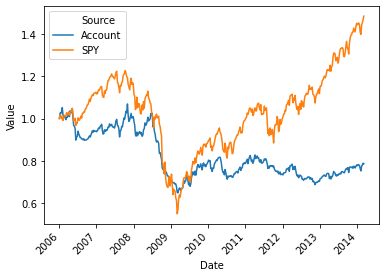

In [159]:
df_tracking = pd.concat([df_tracking, get_baseline(df_tracking)])
plt.xticks(rotation=45, horizontalalignment='right')
plt.rcParams['figure.figsize'] = (10, 10)
sns.lineplot(data=df_tracking, x='Date', y='Value', hue='Source')